In [1]:
# import relevant libraries
import pandas as pd
import numpy as np
from MEtry import *
from pandas import DataFrame, Series
from collections import defaultdict
import pickle

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

%matplotlib notebook
data=pd.ExcelFile('Dr.Liu_current2.xlsx').parse('Data')


#import data


useful_cols=['good','gen_info','env_info','cs1', 'cs1_mw', 'cs_conc1', 'CS_C1', 'CS_H1', 'CS_O1',
       'cs2', 'cs2_mw', 'cs_conc2', 'CS_C2', 'CS_H2', 'CS_O2', 'cs3', 'cs3_mw',
       'cs_conc3', 'CS_C3', 'CS_H3', 'CS_O3', 'reactor_type', 'rxt_volume',
       'media', 'temp', 'oxygen', 'strain_background',
       'strain_background_genotype', 'strain_background_genotype_modification',
       'genes_modified', 'gene_deletion', 'gene_overexpression',
       'heterologous_gene', 'replication_origin', 'codon_optimization',
       'sensor_regulator', 'enzyme_redesign_evolution', 'protein_scaffold',
       'dir_evo', 'Mod_path_opt', 'product_name', 'no_C', 'no_H', 'no_O',
       'no_N', 'mw', 'precursor', 'enzyme_steps', 'atp_cost',
       'nadh_nadph_cost', 'yield', 'yield_o', 'yield2', 'titer', 'rate',
       'fermentation_time', 'bio_titre']

so_far_zero_cols=['Mod_path_opt','dir_evo','protein_scaffold','enzyme_redesign_evolution','sensor_regulator']

so_far_useless=['precursor','nadh_nadph_cost','enzyme_steps', 'atp_cost','yield_o']


useful_cols=list(set(useful_cols)-set(so_far_zero_cols)-set(so_far_useless))

# drop unnecessary baggage
sdata=data.loc[:,useful_cols]
sdata.drop(sdata[sdata.good==0].index,inplace=True)
sdata.drop(axis=1,labels='good',inplace=True)

# data=sdata.copy()

# # basic preprocessing


#2 temporary strain background genotype
# sbg,sbg_ins, sbg_del for frac of added and deleted genes
sdata['sbg']=sdata.strain_background_genotype.apply(lambda x: len(x) if isinstance(x,str) else 0)
sdata['sbg_del']=sdata.strain_background_genotype_modification.apply(lambda x: x.replace(',','').count('0')/len(x.replace(',',''))
                                                                    if isinstance(x,str) else 0)
sdata['sbg_ins']=sdata.strain_background_genotype_modification.apply(lambda x: x.replace(',','').count('1')/len(x.replace(',',''))
                                                                    if isinstance(x,str) else 0)


#3 temporary genetic modification (numbers and fractions)
# gene_mod, gene_del,gene_native,gene_codon_opt,rep_org
sdata['gene_mod']=sdata.genes_modified.apply(lambda x: len(x) if isinstance(x,str) else 0)
sdata['gene_del']=sdata.gene_deletion.apply(lambda x: x.replace(',','').count('1')/len(x.replace(',','')) \
                                         if isinstance(x,str) else 0)
sdata['gene_exp']=sdata.gene_overexpression.apply(lambda x: x.replace(',','').count('1')/len(x.replace(',','')) \
                                               if isinstance(x,str) else 0)
sdata['gene_het']=sdata.heterologous_gene.apply(lambda x: x.replace(',','').count('0')/len(x.replace(',','')) \
                                               if isinstance(x,str) else 0)
sdata['gene_codon_opt']=sdata.codon_optimization.apply(lambda x: x.replace(',','').count('1')/len(x.replace(',','')) \
                                               if isinstance(x,str) else 0)

#4 fraction of modified genes on different replication origins
reps= ['rep'+ str(x) for x in range(1,16)]
for index, rep in enumerate(reps):
    temp_str='sdata['+"'"+'rep'+ str(index)+"']"+'=sdata.replication_origin.apply(lambda x:' + r"""x.replace(',','')"""+'.count(' +"'"+ str(index+1)+"'"+')/len('+ r"""x.replace(',','')) """+ 'if isinstance(x,str) else 0)'
    exec(temp_str)


    
# # remove processed fields
proc_fields=['replication_origin','strain_background_genotype','strain_background','codon_optimization',\
             'strain_background_genotype_modification','genes_modified','gene_deletion','gene_overexpression', \
            'heterologous_gene']
# sdata.drop(axis=1, labels=proc_fields,inplace=True)

#5 convert categorical variables to continuous using one-hot encoding
toCont=['cs1','cs2','cs3','reactor_type', 'media','oxygen', 'product_name']

plot_data=sdata.copy() # create copy of database for visualizations

sdata=pd.get_dummies(sdata,columns=toCont)


target_cols=['titer', 'rate','yield']

feature_cols=list(set(sdata.columns)-set(target_cols)- set(['bio_titre','yield2','bio_growth_rate'])-set(proc_fields))
feature_cols2=list(set(sdata.columns)-set(target_cols)- set(['bio_titre','yield2','bio_growth_rate'])-set(proc_fields))

X_data=sdata[feature_cols]

plot_data.to_pickle('plot_data.pickle')


In [2]:
# Feature Engineering using metabolic network reconstructions
import cobra
from cobra.flux_analysis import sample,pfba,flux_variability_analysis
from cobra.flux_analysis.sampling import OptGPSampler, ACHRSampler
from cobra import Reaction, Metabolite, Model
from cobra.flux_analysis.loopless import add_loopless, loopless_solution

iML=cobra.io.load_matlab_model('iML1515.mat')
iML.reactions.EX_o2_e.bounds=(-18,1000.) #fix oxygen bounds
iML.reactions.EX_glc__D_e.bounds= (0.0,1000) # remove glucose feed

In [3]:
import warnings
warnings.simplefilter('ignore')
# features to added
sbg_pre={} # fraction of genes modified in strain background that are present in GPR dict
mod_pre={} # fraction of genes modified in wild type that are present in GPR dict
sim_grw={} # 0 or 1 if the strain grows in silico

max_grw={} # max growth of in silico strain
max_yield={} # max yield of in silico strain

yield50_grw={} # growth at 50% yield
grw50_yield={} # yield at 50% growth

prod_class={} # 1: native 2: heterogenous (metabolite available) 3: heterogenous (proxy metabolite used)

counter=0
base_model=iML.copy()
base_model.reactions.EX_glc__D_e.lower_bound=-10.
for label in sdata.index:
    with iML as temp_model:
#     temp_model=iML.copy()
    # model to be used if things get messy
        

        #product
        product_=data.product_name.loc[label] # should confirm this (data or sdata?)
#         prod_class.append(prod_type_dict[product_]) # native or heterologous
        prod_class[label]=prod_type_dict[product_] # native or heterologous
        product=prod_dict[product_]

        # set environmental conditions

        #carbon sources
        cs1=str(data.cs1.loc[label]).replace('.0','')
        cs2=str(data.cs2.loc[label]).replace('.0','')
        cs3=str(data.cs3.loc[label]).replace('.0','')

        if (cs1=='0') or (cs1=='nan'):
            cs1='1'

        # aerobic conditions
        oxy=str(data.oxygen.loc[label]).replace('.0','')

        # apply environmental constraints
        temp_model,safe_model,sim_grw_flag=add_env_info(temp_model,base_model,product,biorxn,oxy,oxy_dict,cs_dict,cs1,cs2,cs3)



        # genetic modifications 
        if not(isinstance(data.strain_background_genotype.loc[label],str)):
            back_genes=['none']
            back_genes_a=[0]
        else:
    #         print('yep')
            temp_var=data.strain_background_genotype_modification.loc[label]
            if not(isinstance(temp_var,str)):
                temp_var=str(temp_var)
            back_genes_a=temp_var.strip().split(',')
            back_genes=sdata.strain_background_genotype.loc[label].strip().split(',')

        if not(isinstance(data.genes_modified.loc[label],str)):
            mod_genes=['none']
            mod_genes_a=[0]
        else:
            temp_var=data.gene_overexpression.loc[label]
            if not(isinstance(temp_var,str)):
                temp_var=str(temp_var)
            mod_genes_a=temp_var.strip().split(',')
            mod_genes=sdata.genes_modified[label].strip().split(',')


        #first convert common gene names to b names if available
        back_genes_conv={gene_dict.get(x.strip(),x.strip()): y for x,y in zip(back_genes,back_genes_a)}
        mod_genes_conv={gene_dict.get(x.strip(),x.strip()): y for x,y in zip(mod_genes,mod_genes_a)}

        total_back_genes=len(back_genes_conv)
        total_mod_genes=len(mod_genes_conv)

        # find  50% of max growth rate
        if sim_grw_flag==0:
            temp_model=safe_model
#             sbg_pre.append(0)   
#             mod_pre.append(0)
            sbg_pre[label]=0 
            mod_pre[label]=0

        else :
            temp_sol=temp_model.optimize()
            max_grw50=temp_sol.objective_value * 0.5
            temp_model,safe_model,sim_grw_flag,back_genes=add_genetic_info(temp_model,safe_model,back_genes_conv,
                                                                GPR_dict,product,biorxn,max_grw50)
            if sim_grw_flag==0:
                temp_model=safe_model
#                 sbg_pre.append(0)   
#                 mod_pre.append(0)
                sbg_pre[label]=0 
                mod_pre[label]=0
            else:
                temp_model,safe_model,sim_grw_flag,mod_genes=add_genetic_info(temp_model,safe_model,mod_genes_conv,
                                                                GPR_dict,product,biorxn,max_grw50)
                if sim_grw_flag==0:
                    temp_model=safe_model
#                     sbg_pre.append(0)   
#                     mod_pre.append(0)
                    sbg_pre[label]=0 
                    mod_pre[label]=0
                else:
#                     sbg_pre.append(back_genes/total_back_genes)   
#                     mod_pre.append(mod_genes/total_mod_genes) 
                    sbg_pre[label]=back_genes/total_back_genes 
                    mod_pre[label]=mod_genes/total_mod_genes

#         sim_grw.append(sim_grw_flag)
        sim_grw[label]=sim_grw_flag

        #5) run four simulations to compute max_grw, max_yield, yield50_grw, grw50_yield
        #  and update database with relevant features

        with temp_model as temp_temp_model:
            # maximum growth
            temp_temp_model.objective=biorxn
            temp_1=temp_temp_model.optimize()
#             max_grw.append(temp_1.objective_value)
            max_grw[label]=temp_1.objective_value*(temp_1.objective_value>=1e-6)


            #maximum yield
            temp_temp_model.objective=product
            temp_2=temp_temp_model.optimize()
            total_carbon=0
            for ind,cs in enumerate([cs1,cs2,cs3]):
                if cs!='0':
                    total_carbon+=abs(temp_2.fluxes[cs_dict[cs]]*sdata.loc[label,'cs'+str(ind+1)+'_mw'])

            temp_yield=temp_2.objective_value*sdata.mw.loc[label]/total_carbon
#             max_yield.append(temp_yield)
            max_yield[label]=temp_yield*(temp_yield>=1e-6)

            # maximum yield at 50% biomass growth
            temp_temp_model.reactions.get_by_id(biorxn).bounds=(0.5*temp_1.objective_value,0.5*temp_1.objective_value)
            temp_3=temp_temp_model.optimize()
            total_carbon=0
            for ind,cs in enumerate([cs1,cs2,cs3]):
                if cs!='0':
                    total_carbon+=abs(temp_3.fluxes[cs_dict[cs]]*sdata.loc[label,'cs'+str(ind+1)+'_mw'])

            temp_yield=temp_3.objective_value*sdata.mw.loc[label]/total_carbon
#             grw50_yield.append(temp_yield)
            grw50_yield[label]=temp_yield*(temp_yield>=1e-6)

            # maximum growth at 50% yield
            temp_temp_model.objective=biorxn
            temp_temp_model.reactions.get_by_id(biorxn).bounds=(0.,1000.)
            temp_temp_model.reactions.get_by_id(product).bounds=(0.5*temp_2.objective_value,0.5*temp_2.objective_value)
            temp_4=temp_temp_model.optimize()
#             yield50_grw.append(temp_4.objective_value)
            yield50_grw[label]=temp_4.objective_value*(temp_4.objective_value>=1e-6)
        counter+=1
        if (counter%200)==0:
            print(counter)
       
     

200
400
600
800
1000


In [4]:
# update data with new features
sdata['yield50_grw']=pd.Series(yield50_grw)
sdata['grw50_yield']=pd.Series(grw50_yield)
sdata['max_grw']=pd.Series(max_grw)
sdata['max_yield']=pd.Series(max_yield)
sdata['sbg_pre']=pd.Series(sbg_pre)
sdata['mod_pre']=pd.Series(mod_pre)
sdata['prod_class']=pd.Series(prod_class)

remove_error=lambda x: 0 if (np.isnan(x) or np.isinf(x)) else x
sdata.grw50_yield=sdata.grw50_yield.apply(remove_error)
sdata.yield50_grw=sdata.yield50_grw.apply(remove_error)
sdata.max_yield=sdata.max_yield.apply(remove_error)
sdata.max_grw=sdata.max_grw.apply(remove_error)

In [5]:
#update feature cols
feature_cols.extend(['yield50_grw','grw50_yield','max_grw','max_yield','sbg_pre','mod_pre','prod_class'])

In [6]:
#import libraries

from sklearn.linear_model import LinearRegression,Ridge,Lasso,PassiveAggressiveRegressor, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler,StandardScaler,Imputer,FunctionTransformer
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split, validation_curve,GridSearchCV,learning_curve,cross_val_score,KFold
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor, ExtraTreesRegressor,BaggingRegressor 
from sklearn.base import TransformerMixin
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.decomposition import PCA
from sknn.mlp import Regressor, Layer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from mlxtend.regressor import StackingRegressor
from scipy.stats import pearsonr

# keep_out=['lycopene','l-alanine','acrylic_acid','l-malate','Isobutanol']
# keep_in =list(set(data.product_name.unique())- set(keep_out))

# keep_in_index=data.index[data.product_name.apply(lambda x: True if x in keep_in else False)]

# keep_out_index=list(set(data.index)-set(keep_in_index))


Using TensorFlow backend.


In [7]:
X_train={}
X_test={}

y_train={}
y_test={}



for target in target_cols:
    y_data=sdata[target]
    flag=y_data.apply(lambda x: not(np.isnan(x)) and not(np.isinf(x)))
    temp_y_data=y_data[flag]
    
    temp_S_data=sdata.loc[sdata.index[flag],:]
    temp_X_train, temp_X_test, y_train[target], y_test[target] = \
    train_test_split(temp_S_data, temp_y_data,random_state=56,test_size=.1,shuffle=True)
    
    X_train[target]=temp_X_train[feature_cols]
    X_test[target]=temp_X_test[feature_cols]
    
    


In [8]:
# elastic net
from collections import defaultdict
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

en_grid=defaultdict(GridSearchCV)

units={'titer':'(g Product/L)','rate':'(g Product/L/h)', 'yield': '(g Product/ g CarbonSource)'}


param_grid=[
    {'final_estimator__alpha':np.logspace(-4, 1, 15),
     'final_estimator__l1_ratio':np.linspace(0.1,.9,15),
          
     }
]


M1=ElasticNet()

temp_pipe=Pipeline([('imputer',Imputer(missing_values='NaN',axis=0)), 
             ('scaler',StandardScaler()), ('pca',PCA(n_components = 40)),
                    ('final_estimator',M1)])

for target in target_cols:

    temp_grid_old=GridSearchCV(temp_pipe,param_grid=param_grid,cv=5,n_jobs=1,refit=True,scoring='r2')
    


    _=temp_grid_old.fit(X_train[target],y_train[target])plt

    
    print('For ' + target )
    print('***************************************')
    print("Best cross-validation accuracy: {:.2f}".format(temp_grid_old.best_score_))
    print("Test set score: {:.2f}".format(temp_grid_old.score(X_test[target], y_test[target])))
    print("Best parameters: {}".format(temp_grid_old.best_params_))
    y1=temp_grid_old.predict(X_train[target])
    
    print(r2_score(y_train[target],y1))

    y2=temp_grid_old.predict(X_test[target])
    print(r2_score(y_test[target],y2))
    
#     if target=='titer':
    
#         cv = ShuffleSplit(n_splits=100, test_size=0.1, random_state=56)
#         title=target + ' Learning Curve'
#         plot_learning_curve(estimator=temp_grid_old, n_jobs=1,title=title, X=X_train[target], y=y_train[target],cv=cv)
    
   
    en_grid[target]=temp_grid_old

For titer
***************************************
Best cross-validation accuracy: 0.20
Test set score: 0.28
Best parameters: {'final_estimator__alpha': 0.37275937203149417, 'final_estimator__l1_ratio': 0.61428571428571432}
0.219331273407
0.282119830296
For rate
***************************************
Best cross-validation accuracy: 0.22
Test set score: 0.51
Best parameters: {'final_estimator__alpha': 0.37275937203149417, 'final_estimator__l1_ratio': 0.10000000000000001}
0.294337073265
0.510764039857
For yield
***************************************
Best cross-validation accuracy: 0.14
Test set score: 0.55
Best parameters: {'final_estimator__alpha': 1.9306977288832496, 'final_estimator__l1_ratio': 0.10000000000000001}
0.433113808195
0.54788759891


In [9]:
# nearest neighbor regression
from collections import defaultdict
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

knn_grid=defaultdict(GridSearchCV)


units={'titer':'(g Product/L)','rate':'(g Product/L/h)', 'yield': '(g Product/ g CarbonSource)'}


param_grid=[
    {'final_estimator__n_neighbors':[i for i in range(19,40)],
     'final_estimator__weights':['uniform','distance'],
     
     }
]


M1=KNeighborsRegressor()

temp_pipe=Pipeline([('imputer',Imputer(missing_values='NaN',axis=0)), 
             ('scaler',StandardScaler()), ('pca',PCA(n_components = 40)),
                    ('final_estimator',M1)])

for target in target_cols:
    temp_grid_old=GridSearchCV(temp_pipe,param_grid=param_grid,cv=5,n_jobs=1,refit=True,scoring='r2')

   

    _=temp_grid_old.fit(X_train[target],y_train[target])


    print('For ' + target)
    print('***************************************')
    print("Best cross-validation accuracy: {:.2f}".format(temp_grid_old.best_score_))
    print("Test set score: {:.2f}".format(temp_grid_old.score(X_test[target], y_test[target])))
    print("Best parameters: {}".format(temp_grid_old.best_params_))
    y1=temp_grid_old.predict(X_train[target])

    print(r2_score(y_train[target],y1))

    y2=temp_grid_old.predict(X_test[target])
    print(r2_score(y_test[target],y2))
    
#     if target=='titer':
#         cv = ShuffleSplit(n_splits=100, test_size=0.1, random_state=56)
#         title=target + ' Learning Curve'
#         plot_learning_curve(estimator=temp_grid_old, n_jobs=1,title=title, X=X_train[target], y=y_train[target],cv=cv)

   
    knn_grid[target]=temp_grid_old
    



For titer
***************************************
Best cross-validation accuracy: 0.77
Test set score: 0.91
Best parameters: {'final_estimator__n_neighbors': 19, 'final_estimator__weights': 'distance'}
0.866004080923
0.90871214285
For rate
***************************************
Best cross-validation accuracy: 0.27
Test set score: 0.65
Best parameters: {'final_estimator__n_neighbors': 37, 'final_estimator__weights': 'distance'}
0.790646956971
0.653920639444
For yield
***************************************
Best cross-validation accuracy: 0.20
Test set score: 0.87
Best parameters: {'final_estimator__n_neighbors': 36, 'final_estimator__weights': 'distance'}
0.924538634976
0.870133304358


In [10]:
#svr

from collections import defaultdict
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

svr_grid=defaultdict(GridSearchCV)



units={'titer':'(g Product/L)','rate':'(g Product/L/h)', 'yield': '(g Product/ g CarbonSource)'}


C_dict={'titer':[10000,20500,25000],'rate':[1000,2000,5000,7000,9000],'yield':[500,1000,2000,4000,5000]}
g_dict={'titer':[0.01,0.05,0.1,0.15,0.2,'auto'],'rate':[0.01,0.05,0.1,0.15,0.2,'auto'],'yield':[0.01,0.05,0.1,0.15,0.2,'auto']}

M1=SVR(kernel='rbf')


temp_pipe=Pipeline([('imputer',Imputer(missing_values='NaN',axis=0)), 
             ('scaler',StandardScaler()), ('pca',PCA(n_components = 40)),
                    ('final_estimator',M1)])

for target in target_cols:
    param_grid=[
        {'final_estimator__gamma':g_dict[target],
         'final_estimator__C':C_dict[target],
        }
        ]
    
    temp_grid_old=GridSearchCV(temp_pipe,param_grid=param_grid,cv=5,n_jobs=1,refit=True,scoring='r2')

  

    _=temp_grid_old.fit(X_train[target],y_train[target])
  

    print('For ' + target )
    print('***************************************')
    print("Best cross-validation accuracy: {:.2f}".format(temp_grid_old.best_score_))
    print("Test set score: {:.2f}".format(temp_grid_old.score(X_test[target], y_test[target])))
    print("Best parameters: {}".format(temp_grid_old.best_params_))
    y1=temp_grid_old.predict(X_train[target])

    print(r2_score(y_train[target],y1))

    y2=temp_grid_old.predict(X_test[target])
    print(r2_score(y_test[target],y2))

#     if target=='titer':
#         cv = ShuffleSplit(n_splits=100, test_size=0.1, random_state=56)
#         title=target + ' Learning Curve'
#         plot_learning_curve(estimator=temp_grid_old, n_jobs=1,title=title, X=X_train[target], y=y_train[target],cv=cv)
        
    svr_grid[target]=temp_grid_old
    

For titer
***************************************
Best cross-validation accuracy: 0.85
Test set score: 0.88
Best parameters: {'final_estimator__C': 10000, 'final_estimator__gamma': 'auto'}
0.911065492142
0.877408068045
For rate
***************************************
Best cross-validation accuracy: 0.02
Test set score: 0.75
Best parameters: {'final_estimator__C': 1000, 'final_estimator__gamma': 0.1}
0.917146305741
0.75358169706
For yield
***************************************
Best cross-validation accuracy: -0.17
Test set score: 0.84
Best parameters: {'final_estimator__C': 2000, 'final_estimator__gamma': 0.1}
0.926205567084
0.837637536014


In [11]:
#xgb
from collections import defaultdict
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

xgb_grid=defaultdict(GridSearchCV)


M1=XGBRegressor()

temp_pipe=Pipeline([('imputer',Imputer(missing_values='NaN',axis=0)), 
             ('scaler',StandardScaler()), ('pca',PCA(n_components = 40)),
                    ('final_estimator',M1)])

param_grid={
 'final_estimator__learning_rate':[0.01,0.02,0.03,0.04,0.05,0.1,0.2,0.4,0.5],
#      'final_estimator__subsample':[0.2,0.4,0.6,0.8,1],
#      'final_estimator__colsample_bytree':[0.2,0.4,0.6,0.8,1],
#      'final_estimator__max_depth':[2,3,5,7,8,9],
#      'final_estimator__min_child_weight':[1,2,4,6,8,9],
'final_estimator__n_estimators':[3,5,7,10,12,30,50,100,500,1000,1500,2000]
}

for target in target_cols:
    temp_grid_old=GridSearchCV(temp_pipe,param_grid=param_grid,cv=5,n_jobs=1,refit=True,scoring='r2')



    _=temp_grid_old.fit(X_train[target],y_train[target])


    print('For ' + target)
    print('***************************************')
    print("Best cross-validation accuracy: {:.2f}".format(temp_grid_old.best_score_))
    print("Test set score: {:.2f}".format(temp_grid_old.score(X_test[target], y_test[target])))
    print("Best parameters: {}".format(temp_grid_old.best_params_))
    y1=temp_grid_old.predict(X_train[target])

    print(r2_score(y_train[target],y1))

    y2=temp_grid_old.predict(X_test[target])
    print(r2_score(y_test[target],y2))
    
#     if target=='titer':
#         cv = ShuffleSplit(n_splits=100, test_size=0.1, random_state=56)
#         title=target + ' Learning Curve'
#         plot_learning_curve(estimator=temp_grid_old, n_jobs=1,title=title, X=X_train[target], y=y_train[target],cv=cv)
    
    xgb_grid[target]=temp_grid_old
  
 

For titer
***************************************
Best cross-validation accuracy: 0.86
Test set score: 0.83
Best parameters: {'final_estimator__learning_rate': 0.02, 'final_estimator__n_estimators': 1000}
0.907379544457
0.83077789194
For rate
***************************************
Best cross-validation accuracy: 0.17
Test set score: 0.34
Best parameters: {'final_estimator__learning_rate': 0.02, 'final_estimator__n_estimators': 50}
0.62637413863
0.343669434221
For yield
***************************************
Best cross-validation accuracy: 0.23
Test set score: 0.52
Best parameters: {'final_estimator__learning_rate': 0.1, 'final_estimator__n_estimators': 7}
0.597810401205
0.517959688227


In [12]:
def plot_learning_curve(estimator, title, X, y, ylim=None,xlim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.8,1,10)):
    from sklearn.model_selection import learning_curve
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    if xlim is not None:
        plt.xlim(*xlim)
        
    if cv is not None:
        cv=cv
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, 
                                                            n_jobs=n_jobs, train_sizes=train_sizes,shuffle=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


<IPython.core.display.Javascript object>


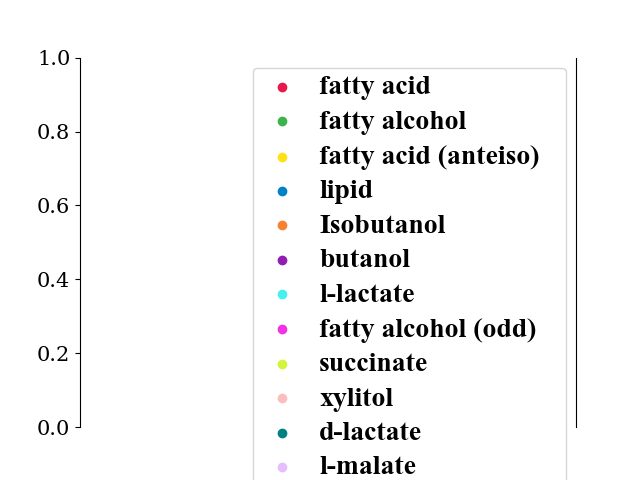

In [13]:
import matplotlib as mpl
color_list=['#e6194b','#3cb44b','#ffe119','#0082c8','#f58231','#911eb4','#46f0f0','#f032e6','#d2f53c','#fabebe',
'#008080','#e6beff','#aa6e28','#fffac8','#800000','#aaffc3','#808000','#ffd8b1','#000080','#808080','#FFFFFF','#000000',
'#e8514b','#3cb00b','#ffe517','#1097c8','#f50239','#918eb6','#76f1f0','#f432e5','#d0f93c','#f9bdbe']


color_dict=dict(zip(data.product_name.unique(),color_list))

#plot color legend
labelfont = {'fontname':'Times New Roman','fontweight':'bold'}

mpl.rcParams.update({'font.size':15,'font.family':'serif'})

fig=plt.figure()
markers=[plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in [color_dict[x] for x in color_dict.keys()]]
lg=plt.legend(markers, data.product_name.unique(), numpoints=1)
for text in lg.get_texts():
    text.set_fontname('Times New Roman')
    text.set_fontsize(20)
    text.set_fontweight('bold')

ax=fig.gca()
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_visible(False)

In [17]:
# grand model
import matplotlib.cm as cm

labelfont = {'fontname':'Times New Roman','fontweight':'bold'}


master_grids=defaultdict(GridSearchCV)
master_grids2=defaultdict(GridSearchCV)

units={'titer':'(g Product/L)','rate':'(g Product/L/h)', 'yield': '(g Product/ g CarbonSource)'}


param_grid={
     'meta-xgbregressor__learning_rate':[0.01,0.02,0.03,0.04,0.05,0.1,0.2,0.4,0.5],
#      'meta-xgbregressor__subsample':[0.4,0.6,0.8],
#      'meta-xgbregressor__colsample_bytree':[0.4,0.6,0.8],
#      'meta-xgbregressor__max_depth':[2,3,5,7,8],
#      'meta-xgbregressor__min_child_weight':[1,2,4,6,8,9],
#      'meta-xgbregressor__gamma':st.uniform(0, 10),
#     'meta-xgbregressor__reg_alpha':st.expon(0, 50),
   'meta-xgbregressor__n_estimators':[3,5,7,10,12,30,50,100,500,1000,1500,2000]
}


#  'final_estimator__learning_rate':[0.01,0.02,0.03,0.04,0.05,0.1,0.2,0.4,0.5],
# #      'final_estimator__subsample':[0.2,0.4,0.6,0.8,1],
# #      'final_estimator__colsample_bytree':[0.2,0.4,0.6,0.8,1],
# #      'final_estimator__max_depth':[2,3,5,7,8,9],
# #      'final_estimator__min_child_weight':[1,2,4,6,8,9],
# 'final_estimator__n_estimators':[3,5,7,10,12,30,50,100,500,1000,1500,2000]

M1=XGBRegressor()


all_grids=[en_grid,knn_grid,svr_grid,xgb_grid]


for target in target_cols:
    R_en,R_knr,R_svr,R_xgb =[x[target].best_estimator_ for x in all_grids]
   

    temp_stack= StackingRegressor(regressors=[R_xgb,R_svr,R_en,R_knr],meta_regressor=M1)
    temp_grid_old=GridSearchCV(temp_stack,param_grid=param_grid,cv=5,n_jobs=1,refit=True,scoring='r2')
    
  
    _=temp_grid_old.fit(X_train[target],y_train[target])
    
 
    print('For ' + target)
    print('***************************************')

    print("Test set score: {:.2f}".format(temp_grid_old.score(X_test[target], y_test[target])))

    y1=temp_grid_old.predict(X_train[target])
    print(r2_score(y_train[target],y1))

    y2=temp_grid_old.predict(X_test[target])
    print(r2_score(y_test[target],y2))
    
    print(pearsonr(y_test[target],y2))
    
    
    _=plt.figure()

    plt.plot(y_test[target], y_test[target], '-', color="k")

    for y_pt in y_test[target].index:
        temp_label=data.loc[y_pt,'product_name']
        _=plt.plot(y_test[target].loc[y_pt], temp_grid_old.predict(X_test[target].loc[y_pt,].reshape(1, -1)), 'o', 
                   color=color_dict[temp_label],
                  label=temp_label)
    plt.title(target + units[target],**labelfont)
    _=plt.xlabel('Experiment',**labelfont)
    _=plt.ylabel('Predicted',**labelfont)
    
    
#     if target=='titer':
    cv = ShuffleSplit(n_splits=100, test_size=0.1, random_state=56)
    title=target + ' Learning Curve'
    plot_learning_curve(estimator=temp_grid_old, n_jobs=1,title=title, X=X_train[target], y=y_train[target],cv=cv)
   
    master_grids[target]=temp_grid_old
    


KeyboardInterrupt: 